In [62]:
import sys, os
sys.path.append('../')

import numpy as np
import data_loader.data_loader as data_loader
from argparse import Namespace
import matplotlib.pyplot as plt
import maxflow
import IPython.display as ipd
from librosa.core import stft, istft

In [4]:
default_parameters = Namespace(batch_size=1, n_jobs=4, get_top=None)
default_parameters.return_items = ['mixture_wav',
                                   'clean_sources_wavs',
                                   'rpd']
default_parameters.input_dataset_p = '/mnt/data/CS544_data/timit_5400_1800_512_2_fm_random_taus_delays/val'
data_gen = data_loader.get_numpy_data_generator(default_parameters)

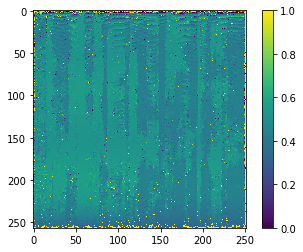

In [93]:
data_gen = iter(data_gen)
batch_data_list = next(data_gen)
numpy_data_list = data_loader.convert_to_numpy(batch_data_list)
mix_wav, clean_wavs, phase_diff = numpy_data_list
phase_diff = np.clip(phase_diff, -2, 2) / 4 + 0.5
mix_stft = stft(mix_wav,
                n_fft=512,
                win_length=512,
                hop_length=128)
spec = np.abs(mix_stft)**2
plt.imshow(phase_diff)
plt.colorbar()

In [100]:
def build_graph_from_img(spec, phase_diff, horiz_weight=1, vert_weight=1):
    height, width = phase_diff.shape
    nodeids = g.add_grid_nodes(phase_diff.shape)
    horiz_diff = np.abs(phase_diff[:, :-1] - phase_diff[:, 1:])
    vert_diff = np.abs(phase_diff[:-1] - phase_diff[1:])
    horiz_diff = np.concatenate([horiz_diff, np.zeros((height, 1))], axis=1)
    vert_diff = np.concatenate([vert_diff, np.zeros((1, width))], axis=0)
    horiz_diff = horiz_diff.reshape(-1)
    vert_diff = vert_diff.reshape(-1)
    
    for row in nodeids:
        for nodeid in row:
            if nodeid % width != width - 1:
                weight = np.exp(-horiz_diff[nodeid]**2)
                weight *= horiz_weight
                g.add_edge(nodeid, nodeid + 1, weight, weight)
                
            if nodeid < width * (height - 1):
                weight = np.exp(-vert_diff[nodeid]**2)
                weight *= vert_weight
                g.add_edge(nodeid, nodeid + width, weight, weight)
                
    # make terminal edges
    g.add_grid_tedges(nodeids, spec, np.max(spec) - spec)
    return g

In [ ]:
g = build_graph_from_img(spec, phase_diff, 10, 0.5)
g.maxflow()
sgm = g.get_grid_segments(nodeids)
plt.imshow(sgm, cmap='gray')

In [96]:
mix_stft = stft(mix_wav,
                n_fft=512,
                win_length=512,
                hop_length=128)
s1_estimate = istft(mix_stft * sgm,
                    win_length=512,
                    hop_length=128)
s2_estimate = istft(mix_stft * (1 - sgm),
                    win_length=512,
                    hop_length=128)
ipd.display(ipd.Audio(mix_wav, rate=16000))
ipd.display(ipd.Audio(s1_estimate, rate=16000))
ipd.display(ipd.Audio(s2_estimate, rate=16000))

/usr/local/anaconda/lib/python3.6/site-packages/IPython/lib/display.py:136: RuntimeWarning: invalid value encountered in true_divide
  scaled = np.int16(data/np.max(np.abs(data))*32767).tolist()
